In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import time
from tqdm import tqdm

from pyhessian.hessian import hessian # Hessian computation
from pyhessian.density_plot import get_esd_plot # ESD plot
from pyhessian.utils import hessian_vector_product # Hessian-vector product
from plot_utils import *

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 4),
            nn.Sigmoid(),
            nn.Linear(4, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()

num_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {num_params}')

Total number of parameters: 3190


In [9]:
# device to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=4, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4, out_features=10, bias=True)
  )
)

In [10]:
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
hessian_dataloader = DataLoader(training_data, batch_size=training_data.data.shape[0])
for inputs, targets in hessian_dataloader:
    break
inputs, targets = inputs.to(device), targets.to(device)

In [11]:
# create hessain computation module
hessian_comp = hessian(model, loss_fn, data=(inputs, targets), cuda=torch.cuda.is_available())

/home/nadezhda/anaconda3/envs/semester_project/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /croot/pytorch-select_1725478810240/work/torch/csrc/autograd/engine.cpp:1203.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


#### Hessian Eigenvalues Spectral Density (using Stochastic Lanczos Quadrature)

In [12]:
start = time.time()
density_eigen, density_weight = hessian_comp.density()
end = time.time()
print(f"Time to compute Hessian ESD (using Stochastic Lanczos Quadrature): {end-start:.2f}s")

Time to compute Hessian ESD (using Stochastic Lanczos Quadrature): 3.14s


/home/nadezhda/Desktop/spectral-properties-of-NN/pyhessian/density_plot.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


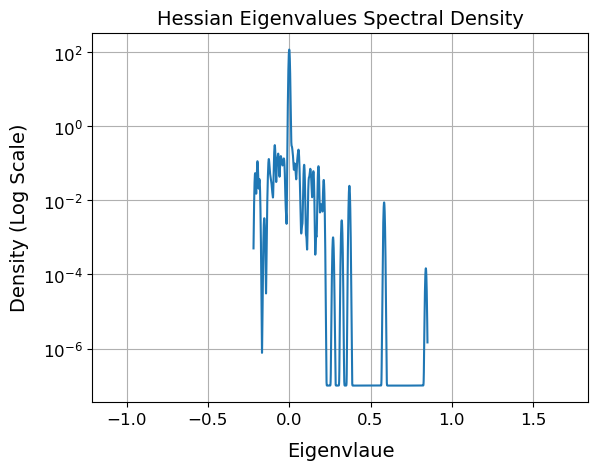

In [13]:
get_esd_plot(density_eigen, density_weight)

#### Hessian Spectrum (using Slow Lanczos)

In [14]:
start = time.time()
eigenvalues = hessian_comp.slow_lanczos_spectrum(iter=num_params)
end = time.time()
print(f"Time to compute Hessian Spectrum (using slow Lanczos): {end-start:.2f}s")

100%|██████████| 3190/3190 [06:47<00:00,  7.82it/s]


Time to compute Hessian Spectrum (using slow Lanczos): 420.39s


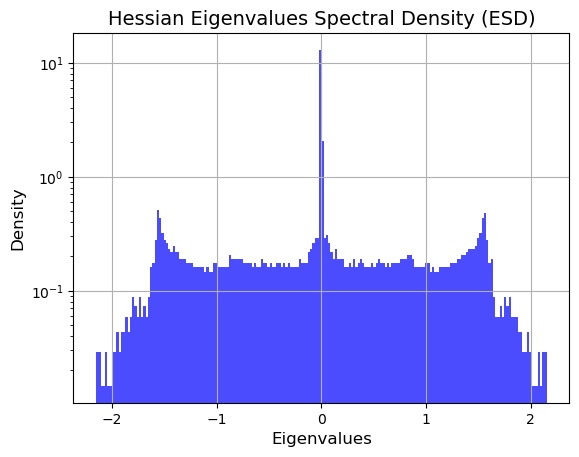

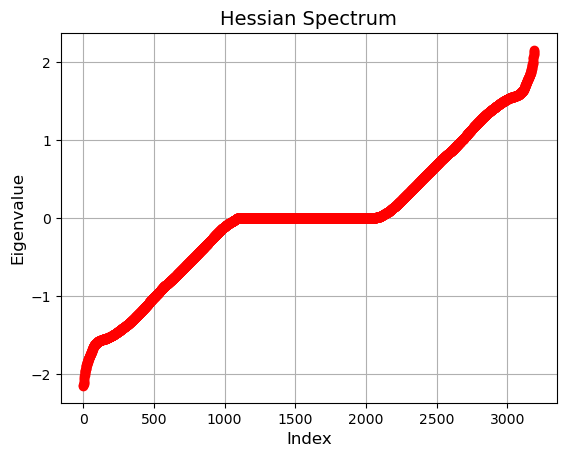

In [15]:
# plot
plot_hessian_spectrum_density(eigenvalues, num_bins=200)
plot_hessian_spectrum(eigenvalues)

#### Hessain Spectrum (using exact Hessian computation + eigendecomposition)

In [18]:
start = time.time()
hessian_hvp = np.zeros((num_params, num_params))
for i in tqdm(range(num_params)):
    v = [torch.zeros(p.size()).to(device) for p in hessian_comp.params]
    # flatten the vector and set the i-th element to 1
    flattened_v = torch.zeros(num_params).to(device)
    flattened_v[i] = 1
    # reshape the vector back to the original shape
    reshaped_v = []
    start = 0
    for t in v:
        numel = t.numel()  # get the number of elements in the current tensor
        reshaped_v.append(flattened_v[start:start + numel].view_as(t))  # reshape the chunk back
        start += numel
    # compute the Hessian-vector product
    hvp = hessian_vector_product(hessian_comp.gradsH, hessian_comp.params, reshaped_v)
    hvp_flat = torch.cat([t.flatten() for t in hvp])
    hessian_hvp[i] = hvp_flat.cpu().detach().numpy()
hessian_hvp = hessian_hvp.T
eigenvalues_hvp, eigenvectors_hvp = np.linalg.eigh(hessian_hvp)
end = time.time()
print(f"Time to compute Hessian Spectrum (using exact Hessian computations + eigendecomposition): {end-start:.2f}s")

100%|██████████| 3190/3190 [01:34<00:00, 33.89it/s]


Time to compute Hessian Spectrum (using exact Hessian computations + eigendecomposition): 1727204595.68s


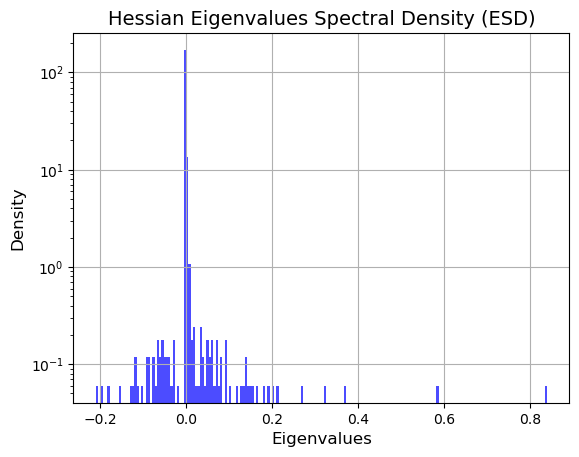

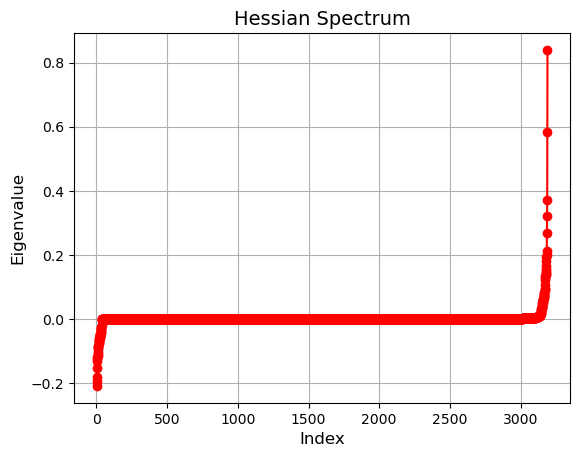

In [17]:
# plot
plot_hessian_spectrum_density(eigenvalues_hvp, num_bins=200)
plot_hessian_spectrum(eigenvalues_hvp)